In [1]:
import numpy as np
import tensorflow as tf
import random as rn
from my_utils import Workout_dataset, class_weight_dict
from my_model import make_CNN_RNN_model

import os

In [2]:
# seed 고정
os.environ['PYTHONHASHSEED'] = str(42)

os.environ['TF_DETERMINISTIC_OPS'] = '1'
os.environ['TF_CUDNN_DETERMINISTIC'] = '1'

tf.random.set_seed(42)
np.random.seed(42)
rn.seed(42)

In [3]:
lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(patience = 5,verbose = 1,factor = 0.5) 

# def scheduler(epoch, lr):
#     if (epoch>20) and (lr > 0.00001):
#         lr = lr*0.9
#         return lr
#     else:
#         return lr

# lr_scheduler = tf.keras.callbacks.LearningRateScheduler(scheduler)

train_dir = './data/train'
label_dir = './data/data_y_train.csv'
test_dir = './data/test'
test_label_dir = './data/data_y_test.csv'
checkpoint_filepath = './save/cnn_gru_best.hdf5'

BATCH_SIZE = 64

train_loader = Workout_dataset(
    train_dir, label_dir, mode='Train',
    fold=0, batch_size=BATCH_SIZE, shuffle=True, 
    augment=True, rot_prob=0.45, perm_prob=0.24)

valid_loader = Workout_dataset(
    train_dir, label_dir, mode='Valid',
    fold=0, batch_size=16, shuffle=True)

test_loader = Workout_dataset(
    test_dir, test_label_dir, mode='Test',
    batch_size=625, shuffle=False)


In [4]:
model = make_CNN_RNN_model(
    lr = 0.001,
    leakyrelu_alpha = 0.2,
    input_kernels = 10,
    input_kernel_width = 3, # #3#
    res_kernels = 60,
    res_kernel_width = 3,
    res_regularize_coeff=0.01, # #0.01#, 0.1, 0.2
    res_num = 9, # 3, 5, 7, #9#
    )

model.summary()

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 600, 3)]     0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 600, 1)]     0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 600, 1)]     0                                            
__________________________________________________________________________________________________
input_5 (InputLayer)            [(None, 600, 3)]     0                                            
____________________________________________________________________________________________

In [5]:

save_best = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath, monitor='val_loss', verbose=1, save_best_only=True,
    save_weights_only=True, mode='auto', save_freq='epoch', options=None)

early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',min_delta=0.0001,
    patience=30,verbose=1)

history = model.fit(
    train_loader,
    validation_data=valid_loader,
    epochs=2000,
    callbacks=[save_best,early_stop,lr_scheduler],
    class_weight=class_weight_dict)


Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.
Epoch 1/2000
34/34 [==============================] - 35s 297ms/step - loss: 43.8925 - accuracy: 0.3070 - val_loss: 32.8231 - val_accuracy: 0.4453

Epoch 00001: val_loss improved from inf to 32.82307, saving model to ./save/cnn_gru_best.hdf5
Epoch 2/2000
34/34 [==============================] - 6s 184ms/step - loss: 28.8428 - accuracy: 0.5510 - val_loss: 21.5930 - val_accuracy: 0.4570

Epoch 00002: val_loss improved from 32.82307 to 21.59301, saving model to ./save/cnn_gru_best.hdf5
Epoch 3/2000
34/34 [==============================] - 6s 182ms/step - loss: 19.0631 - accuracy: 0.6457 - val_loss: 14.7959 - val_accuracy: 0.4570

Epoch 00003: val_loss improved from 21.59301 to 14.79585, saving model to ./save/cnn_gru_best.hdf5
Epoch 4/2000
34/34 [==============================] - 6s 184ms/step - loss: 13.5959 - accuracy: 0.6452 - val_loss: 10.9792 - val

In [6]:

model.load_weights(checkpoint_filepath)
model.evaluate(test_loader,verbose=1)


1/1 [==============================] - 1s 1s/step - loss: 0.7780 - accuracy: 0.8320


[0.7780284881591797, 0.8320000171661377]

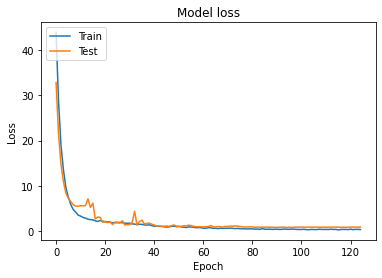

In [7]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()